# Praktikum 2


In [1]:
import numpy as np

np.e * 2

5.43656365691809

In [2]:
import torch
import deepinv
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

In [3]:
print("PyTorch Version:", torch.__version__)
# Prüfen, ob GPU verfügbar ist
if torch.cuda.is_available():
    print("GPU is available.")
    print("GPU Name:", torch.cuda.get_device_name(0))
else:
    print("GPU is not available. Using CPU instead.")

PyTorch Version: 2.9.1+cu128
GPU is available.
GPU Name: NVIDIA GeForce RTX 3070


In [4]:
device = "cuda"
batch_size = 128 # On RTX 3070: Memory Usage ~7800MiB/8192MiB (6800MiB für python process)
image_size = 32

transform = transforms.Compose(
    [
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.0, 0.0, 0.0), (1.0, 1.0, 1.0)),
    ]
)
train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(root="./data", train=True, download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True,
)

lr = 1e-4
epochs = 100

scaler = torch.amp.GradScaler('cuda')

model = (deepinv.models.DiffUNet(in_channels=3,
                                out_channels=3,
                                pretrained=None)
         .to(device))

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
mse = deepinv.loss.MSE()

beta_start = 1e-4
beta_end = 0.02
timesteps = 1000

loss_history = []

betas = torch.linspace(beta_start, beta_end, timesteps, device=device)
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)

for epoch in range(epochs):
    model.train()
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=True)
    for data, _ in pbar:
        imgs = data.to(device)
        noise = torch.randn_like(imgs)
        t = torch.randint(0, timesteps, (imgs.size(0),), device=device)

        noised_imgs = (
            sqrt_alphas_cumprod[t, None, None, None] * imgs
            + sqrt_one_minus_alphas_cumprod[t, None, None, None] * noise
        )

        optimizer.zero_grad()
#        with torch.amp.autocast('cuda'):
#            estimated_noise = model(noised_imgs, t, type_t="timestep")
#            estimated_noise = estimated_noise[:, :3, :, :] # fix output shape
#            loss = mse(estimated_noise, noise).mean()
#            assert loss.dtype is torch.float32

        #loss.backward()
        ##scaler.scale(loss).backward()
        #scaler.step(optimizer)
        #scaler.update()

        #loss_history.append(loss.item())

        estimated_noise = model(noised_imgs, t, type_t="timestep")
        estimated_noise = estimated_noise[:, :3, :, :] # fix output shape
        loss = mse(estimated_noise, noise)
        loss_scalar = loss.mean()
        loss_history.append(loss_scalar.item())
        loss_scalar.backward()
        optimizer.step()
        pbar.set_postfix({"loss": loss_scalar.item()})

    if epoch % 10 == 0:
        torch.save(
            model.state_dict(),
            "trained_diffusion_model" + epoch.__str__() + ".pth",
        )

torch.save(
    model.state_dict(),
    "trained_diffusion_model.pth",
)

Epoch 1/100:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2/100:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 3/100:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 4/100:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 5/100:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 6/100:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 7/100:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 8/100:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 9/100:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 10/100:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 11/100:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 12/100:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 13/100:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 14/100:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 15/100:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 16/100:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 17/100:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 18/100:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 19/100:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 20/100:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 21/100:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 22/100:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 23/100:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 24/100:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 25/100:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 26/100:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 27/100:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 28/100:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 29/100:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 30/100:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 31/100:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 32/100:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 33/100:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 34/100:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 35/100:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 36/100:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 37/100:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 38/100:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 39/100:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 40/100:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 41/100:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 42/100:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 43/100:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 44/100:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 45/100:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 46/100:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 47/100:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 48/100:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 49/100:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 50/100:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 51/100:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 52/100:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 53/100:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 54/100:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 55/100:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 56/100:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 57/100:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 58/100:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 59/100:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 60/100:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 61/100:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 62/100:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 63/100:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 64/100:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 65/100:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 66/100:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 67/100:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 68/100:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 69/100:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 70/100:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 71/100:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 72/100:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 73/100:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 74/100:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 75/100:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 76/100:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 77/100:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 78/100:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 79/100:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 80/100:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 81/100:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 82/100:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 83/100:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 84/100:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 85/100:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 86/100:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 87/100:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 88/100:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 89/100:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 90/100:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 91/100:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 92/100:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 93/100:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 94/100:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 95/100:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 96/100:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 97/100:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 98/100:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 99/100:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 100/100:   0%|          | 0/391 [00:00<?, ?it/s]

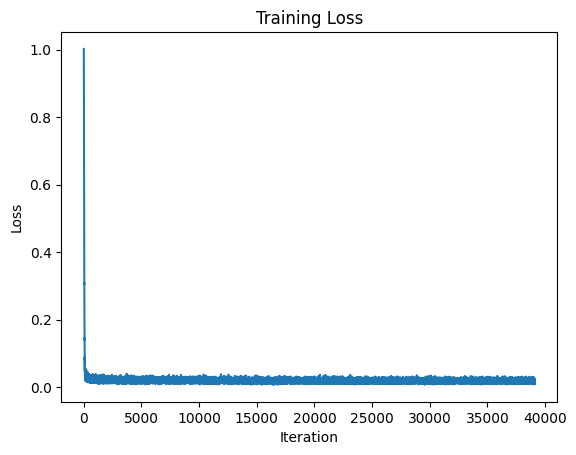

In [5]:
import matplotlib.pyplot as plt

plt.plot(loss_history)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

In [57]:
from pathlib import Path

device = "cuda"
image_size = 32

checkpoint_path = "trained_diffusion_model.pth"
model = deepinv.models.DiffUNet(in_channels=3, out_channels=3, pretrained=Path(checkpoint_path)).to(device)

In [58]:
beta_start = 1e-4
beta_end = 0.02
timesteps = 1000
betas = torch.linspace(beta_start, beta_end, timesteps, device=device)
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)

model.eval()

n_samples = 32

In [59]:
frames = []

with torch.no_grad():
    x = torch.randn(n_samples, 3, image_size, image_size).to(device)

    for t in reversed(range(timesteps)):
        t_tensor = torch.ones(n_samples, device=device).long() * t

        predicted_noise = model(x, t_tensor, type_t="timestep")
        predicted_noise = predicted_noise[:, :3]

        alpha = alphas[t]
        alpha_cumprod = alphas_cumprod[t]
        beta = betas[t]

        if t > 0:
            noise = torch.randn_like(x)
        else:
            noise = 0

        x = (1 / torch.sqrt(alpha)) * (
            x - (beta / torch.sqrt(1 - alpha_cumprod)) * predicted_noise
        ) + torch.sqrt(beta) * noise

        if t % 25 == 0:
            frames.append(x[0].clamp(0,1).cpu())

In [9]:
import imageio

imgs = [(np.transpose(f.numpy(), (1,2,0))*255).astype(np.uint8) for f in frames]
imageio.mimsave("denoising.gif", imgs, fps=20, loop=3)

In [10]:
from IPython.display import HTML
HTML('<img src="denoising.gif" width="320">')

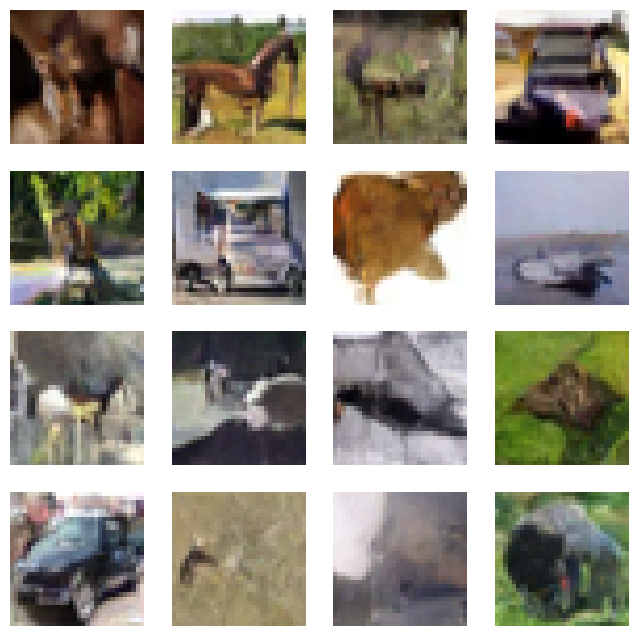

In [60]:
import matplotlib.pyplot as plt
import numpy as np

# x shape: [batch, 3, H, W]
imgs = x.clamp(0, 1).cpu().numpy()   # ensure valid range + move to CPU

n = min(16, imgs.shape[0])  # show up to 16 images
cols = 4
rows = (n + cols - 1) // cols

plt.figure(figsize=(8, 8))

for i in range(n):
    img = np.transpose(imgs[i], (1, 2, 0))  # CHW → HWC
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.axis("off")

plt.show()
